In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [3]:
import time
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
#!pip install pydicom
import pydicom
from pydicom import dcmread
from sklearn.utils import resample # Handle Imbalance
import pathlib
import PIL
import tensorflow_io as tfio
import tensorflow as tf
import keras
keras.backend.set_image_data_format('channels_last')

Using TensorFlow backend.


In [4]:
import tensorflow_io as tfio
import tensorflow as tf
import keras
from keras import backend as K
import matplotlib.pyplot as plt
import time
keras.backend.set_image_data_format('channels_last')
import os


In [7]:
os.chdir(r'C:\Users\Welcome\Desktop\Applied_AI\intuitive-deep-learning-master\Building a Web Application to Deploy Machine Learning Models')

In [5]:
# Read a saved files
dataset = pd.read_csv('siim/train-rle.csv')
df_main = pd.read_csv('Main_CS2_SIIM_All.csv')
df_downsampled = pd.read_csv('Main_CS2_SIIM.csv') # Only negative sampled.

In [10]:
df_downsampled.head(2)

,Encoded_pixel,Path
0,209126 1 1019 6 1015 10 1012 13 1010 14 1008 1...,siim/dicom-images-train/1.2.276.0.7230010.3.1....
1,49820 3 1017 11 1012 13 1009 16 1007 18 1006 1...,siim/dicom-images-train/1.2.276.0.7230010.3.1....


In [8]:
# Metrics 
def dice_coeff(actual,predicted,smooth=1):
  Actual = K.flatten(actual)
  Predict = K.flatten(predicted)
  intersection  = K.sum(Actual *Predict)
  return ((2.* intersection + smooth) / (K.sum(Actual) +K.sum(Predict) +smooth))

In [9]:
# Loading the best model
Segmentation_model   =tf.keras.models.load_model('best_models_Unet_ChexNet.hdf5', custom_objects={'dice_coeff':dice_coeff})
classification_model = tf.keras.models.load_model('best_models_classification.h5')

In [10]:
#Function-  Classification_Segmentation   ---> 
'''Here we are doing two actions, First we predicting whether given image has affected by pneumothorax or not.
    If Yes, Display X-ray with highlighted affected part.
    If No, Display image as it is. 😀
'''

def Classification_Segmentation(X):
  img = tf.io.read_file(X)
  image = tfio.image.decode_dicom_image(img, dtype=tf.uint8,color_dim=True,scale='preserve')
  image = tf.image.convert_image_dtype(image, tf.float32)#converting the image to tf.float32
  image=tf.squeeze(image,[0]) #squeezing the image because the file is of the shape(1,1024,1024,1) and we want (1024,1024,3)
  b = tf.constant([1,1,3], tf.int32)
  image=tf.tile(image,b)#the image is of the shape (1024,1024,1) to make it (1024,1024,3) I am using tf.tile
  image=tf.image.resize(image,size=[256,256])
  image=tf.expand_dims(image,axis=0)

  if classification_model.predict(image)>=0.5:
    print("Pneumothorax has been detected")
    mask=Segmentation_model.predict(image)
    mask=(mask>0.5).astype(np.uint8)

    plt.figure(figsize=(20,6)) 
    plt.title("X-ray image with mask(Predicted)")
    plt.imshow(np.squeeze(image),cmap='gray')
    plt.imshow(np.squeeze(mask),cmap='Reds',alpha=0.3)
    return plt.show()

  else:
    plt.figure(figsize=(20,6))
    print('Person is Healthy, No Pneumothorax is detected')
    plt.imshow(np.squeeze(image),cmap='gray')
    return plt.show()

In [12]:
file_name = "C:\\Users\\Welcome\\Pictures\\Saved Pictures\\1.2.276.0.7230010.3.1.4.8323329.10175.1517875222.467676.dcm"

In [ ]:
start_time = time.time()
Classification_Segmentation(file_name)
print("--- %s seconds --- for execution" % (time.time() - start_time))

Pneumothorax has been detected


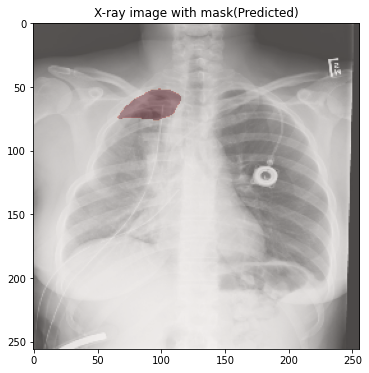

--- 1.3128767013549805 seconds --- for execution


In [13]:
start_time = time.time()
Classification_Segmentation(df_downsampled['Path'][50])
print("--- %s seconds --- for execution" % (time.time() - start_time))

In [14]:
import tensorflow_io as tfio